# Code For Artificial Analysis Data

In [19]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt


#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm
import seaborn as sns



/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1731122314.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


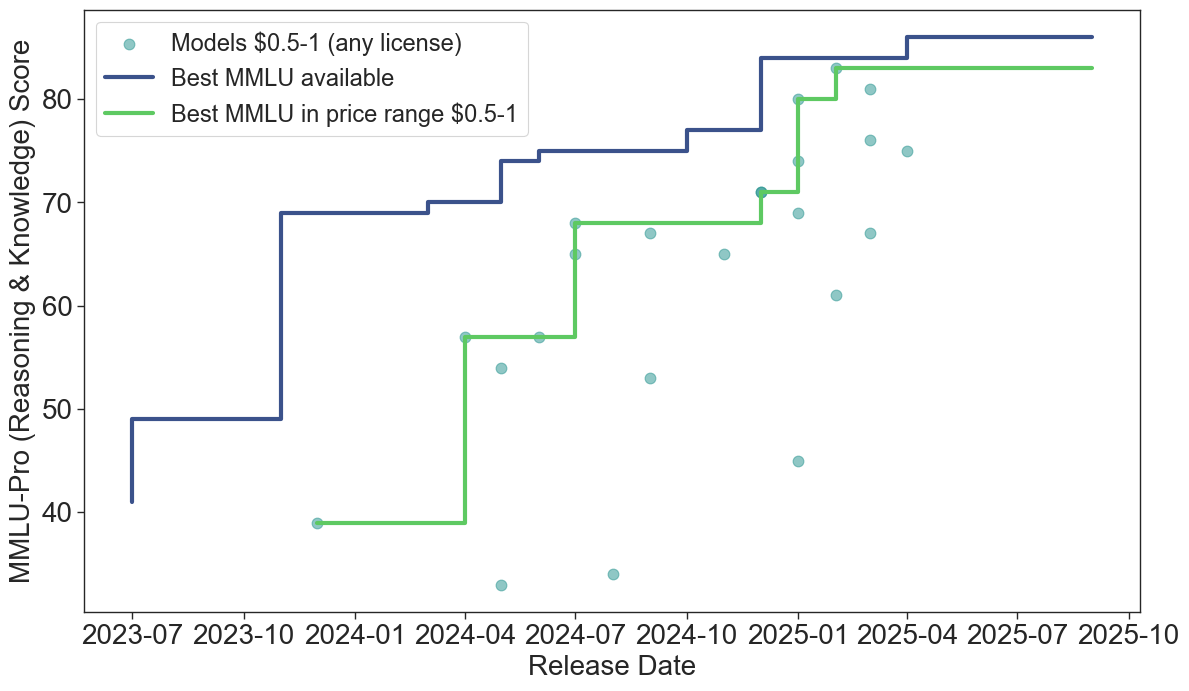

In [20]:
def compare_mmlu_to_best_over_time_any_license(lower_price, upper_price, type=None, benchmark_feature='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plots MMLU performance of models within a fixed price range (optionally filtered by license)
    vs. the best MMLU available at each release date (regardless of license).
    Also plots the best MMLU available within the specified price range.
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime

    default_fontsize  = 20

    sns.set_style("ticks")
    sns.set_context("paper")
    colors = sns.color_palette("viridis", n_colors=3)

    df = pd.read_csv('datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
    # benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    # benchmark_feature = "Chatbot Arena"

    # Drop nan values
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    df = df[df['Output Price\nUSD/1M Tokens'].notna()]

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)

    # Sort by release date
    df = df.sort_values('Release Date')

    # Compute best MMLU available up to each date (across all licenses)
    df['Best_MMLU_So_Far'] = df[benchmark_feature].cummax()
    best_mmlu_df = df[['Release Date', 'Best_MMLU_So_Far']].drop_duplicates(subset='Best_MMLU_So_Far')

    # Filter models in the price range (optionally by license)
    if type is not None:
        price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                      (df['Output Price\nUSD/1M Tokens'] <= upper_price) &
                      (df['License'] == type)]
        label = f'Models ${lower_price}-{upper_price} ({type})'
    else:
        price_df = df[(df['Output Price\nUSD/1M Tokens'] >= lower_price) & 
                      (df['Output Price\nUSD/1M Tokens'] <= upper_price)]
        label = f'Models ${lower_price}-{upper_price} (any license)'
    
    # Compute best MMLU available up to each date within the price range
    price_df = price_df.sort_values('Release Date')
    price_df['Best_MMLU_In_Price_Range'] = price_df[benchmark_feature].cummax()
    best_price_mmlu_df = price_df[['Release Date', 'Best_MMLU_In_Price_Range']].drop_duplicates(subset='Best_MMLU_In_Price_Range')

    # Get the min and max dates from the full dataset for consistent x-axis range
    min_date = df['Release Date'].min()
    max_date = df['Release Date'].max()
    
    # Ensure the best overall MMLU plot starts from the min date and ends at the max date
    if min_date not in best_mmlu_df['Release Date'].values:
        # Add the min date with the first available best MMLU value
        first_best = best_mmlu_df.iloc[0]['Best_MMLU_So_Far']
        best_mmlu_df = pd.concat([pd.DataFrame({'Release Date': [min_date], 'Best_MMLU_So_Far': [first_best]}), 
                                 best_mmlu_df])
    
    if max_date not in best_mmlu_df['Release Date'].values:
        # Add the max date with the last available best MMLU value
        last_best = best_mmlu_df.iloc[-1]['Best_MMLU_So_Far']
        best_mmlu_df = pd.concat([best_mmlu_df, 
                                 pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_So_Far': [last_best]})])
    
    # For the best price range MMLU, start with the first actual data point
    # (don't add min_date if there's no data at that point)
    if len(best_price_mmlu_df) > 0:  # Only if we have models in the price range
        if max_date not in best_price_mmlu_df['Release Date'].values:
            # Add the max date with the last available best price range MMLU value
            last_best_price = best_price_mmlu_df.iloc[-1]['Best_MMLU_In_Price_Range']
            best_price_mmlu_df = pd.concat([best_price_mmlu_df, 
                                         pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_In_Price_Range': [last_best_price]})])
    
    # Sort the dataframes by date to ensure proper step plotting
    best_mmlu_df = best_mmlu_df.sort_values('Release Date')
    best_price_mmlu_df = best_price_mmlu_df.sort_values('Release Date')

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(price_df['Release Date'], price_df[benchmark_feature], label=label, color=colors[1], alpha=0.5, s=60)
    plt.step(best_mmlu_df['Release Date'], best_mmlu_df['Best_MMLU_So_Far'], where='post',linewidth=3, label='Best MMLU available', color=colors[0])
    
    if len(best_price_mmlu_df) > 0:  # Only plot if we have models in the price range
        plt.step(best_price_mmlu_df['Release Date'], best_price_mmlu_df['Best_MMLU_In_Price_Range'], where='post', color=colors[2], linewidth=3, label=f'Best MMLU in price range ${lower_price}-{upper_price}')
    
    plt.xlabel('Release Date', fontsize=default_fontsize)
    plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
    plt.xticks(fontsize=default_fontsize)
    plt.yticks(fontsize=default_fontsize)
    # plt.title(f'{benchmark_feature} of models {label} vs. best available (any license)')
    plt.legend(prop={'size': 17})
    plt.tight_layout()
    plt.savefig(f'Figures/{benchmark_feature[:5]}_cost_comparison.png', dpi=300)
    plt.show()

# Example usage:

compare_mmlu_to_best_over_time_any_license(0.5, 1)  # all licenses in price range
# or, to filter price range by license:
# compare_mmlu_to_best_over_time_any_license(0.5, 1, type='Open')

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/3740374981.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


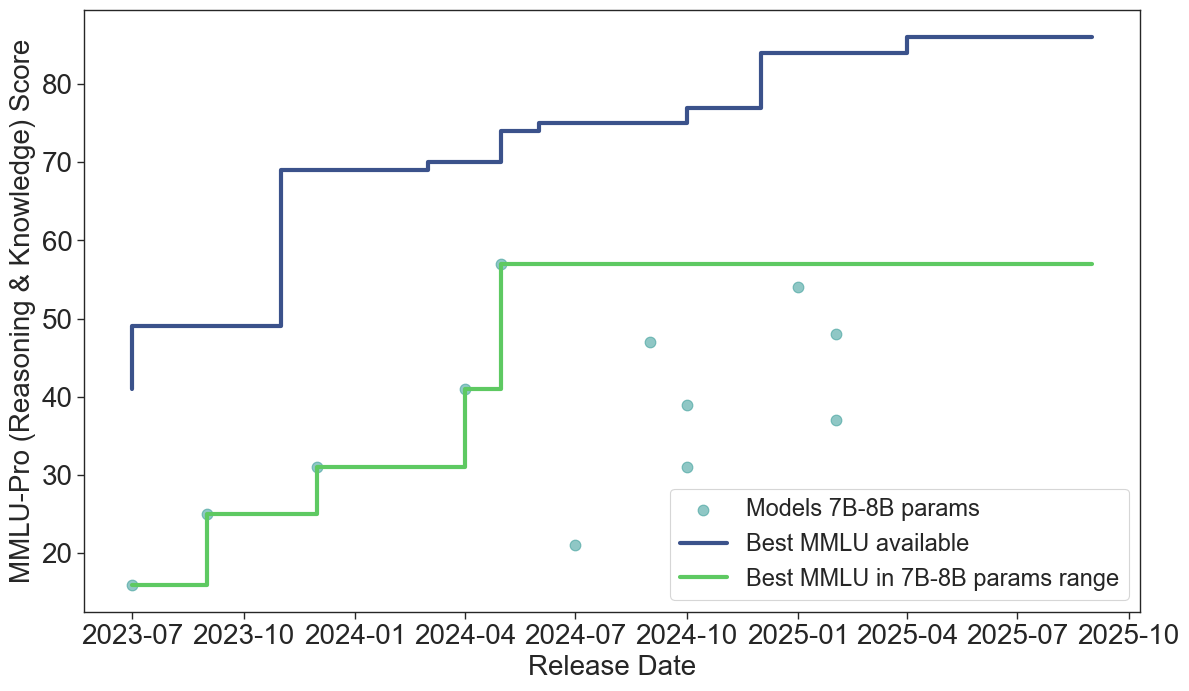

In [21]:
def compare_mmlu_to_best_over_time_by_param_count(lower_param, upper_param, benchmark_feature='MMLU-Pro (Reasoning & Knowledge)'):
    """
    Plots MMLU performance of models within a fixed parameter count range
    vs. the best MMLU available at each release date (regardless of license).
    """
    
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from datetime import datetime

    sns.set_style("ticks")
    sns.set_context("paper")
    default_fontsize  = 20
    colors = sns.color_palette("viridis", n_colors=3)

    df = pd.read_csv('Datasets/art_analysis_scrape.csv')
    df['Release Date'] = pd.to_datetime(df['Release Date'])
    df['Parameter Count'] = pd.to_numeric(df['Parameter Count'], errors='coerce')
    # benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
    # benchmark_feature = "Chatbot Arena"

    # Drop nan values for required fields
    df = df[df[benchmark_feature].notna()]
    df = df[df['Release Date'].notna()]
    
    # Create a copy of the full dataset for best overall MMLU calculation
    df_all = df.copy()

    # Convert MMLU values to float
    if df[benchmark_feature].dtype == 'object':
        df[benchmark_feature] = df[benchmark_feature].str.replace('%', '').astype(float)
        df_all[benchmark_feature] = df_all[benchmark_feature].str.replace('%', '').astype(float)
    else:
        df[benchmark_feature] = df[benchmark_feature].astype(float)
        df_all[benchmark_feature] = df_all[benchmark_feature].astype(float)

    # Sort by release date
    df = df.sort_values('Release Date')
    df_all = df_all.sort_values('Release Date')

    # Compute best MMLU available up to each date (across all models, regardless of parameter count)
    df_all['Best_MMLU_So_Far'] = df_all[benchmark_feature].cummax()
    best_mmlu_df = df_all[['Release Date', 'Best_MMLU_So_Far']].drop_duplicates(subset='Best_MMLU_So_Far')

    # Filter models in the parameter count range (only for those with parameter count available)
    param_df = df[(df['Parameter Count'].notna()) & 
                  (df['Parameter Count'] >= lower_param) & 
                  (df['Parameter Count'] <= upper_param)]
    
    # Compute best MMLU available up to each date within the parameter range
    param_df = param_df.sort_values('Release Date')
    param_df['Best_MMLU_In_Param_Range'] = param_df[benchmark_feature].cummax()
    best_param_mmlu_df = param_df[['Release Date', 'Best_MMLU_In_Param_Range']].drop_duplicates(subset='Best_MMLU_In_Param_Range')

    # Get the full date range for the plot
    min_date = df_all['Release Date'].min()
    max_date = df_all['Release Date'].max()
    
    # Ensure both step plots extend across the full date range
    # For the best overall MMLU, add the last value at the max date if needed
    if best_mmlu_df['Release Date'].max() < max_date:
        last_best_value = best_mmlu_df['Best_MMLU_So_Far'].iloc[-1]
        best_mmlu_df = pd.concat([
            best_mmlu_df,
            pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_So_Far': [last_best_value]})
        ])
    
    # For the parameter-specific MMLU, add the last value at the max date if needed
    if len(best_param_mmlu_df) > 0:  # Only if we have any models in the parameter range
        if best_param_mmlu_df['Release Date'].max() < max_date:
            last_param_best_value = best_param_mmlu_df['Best_MMLU_In_Param_Range'].iloc[-1]
            best_param_mmlu_df = pd.concat([
                best_param_mmlu_df,
                pd.DataFrame({'Release Date': [max_date], 'Best_MMLU_In_Param_Range': [last_param_best_value]})
            ])

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(param_df['Release Date'], param_df[benchmark_feature], alpha=0.5, color=colors[1], label=f'Models 7B-8B params', s=60)
    plt.step(best_mmlu_df['Release Date'], best_mmlu_df['Best_MMLU_So_Far'], where='post', color=colors[0], linewidth=3, label='Best MMLU available')
    
    if len(best_param_mmlu_df) > 0:  # Only plot if we have models in the parameter range
        plt.step(best_param_mmlu_df['Release Date'], best_param_mmlu_df['Best_MMLU_In_Param_Range'], where='post', color=colors[2], linewidth=3, label=f'Best MMLU in 7B-8B params range')
    
    plt.xlabel('Release Date', fontsize=default_fontsize)
    plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
    # plt.title(f'{benchmark_feature} of models (7B-8B params) vs. best available', fontsize=default_fontsize)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(prop={'size': 17})
    plt.tight_layout()
    plt.savefig(f'Figures/{benchmark_feature[:5]}_param_count_comparison.png', dpi=300)
    plt.show()

# Example usage:
compare_mmlu_to_best_over_time_by_param_count(6.9, 8.1)


/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/2800261252.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date']    = pd.to_datetime(df['Release Date'])


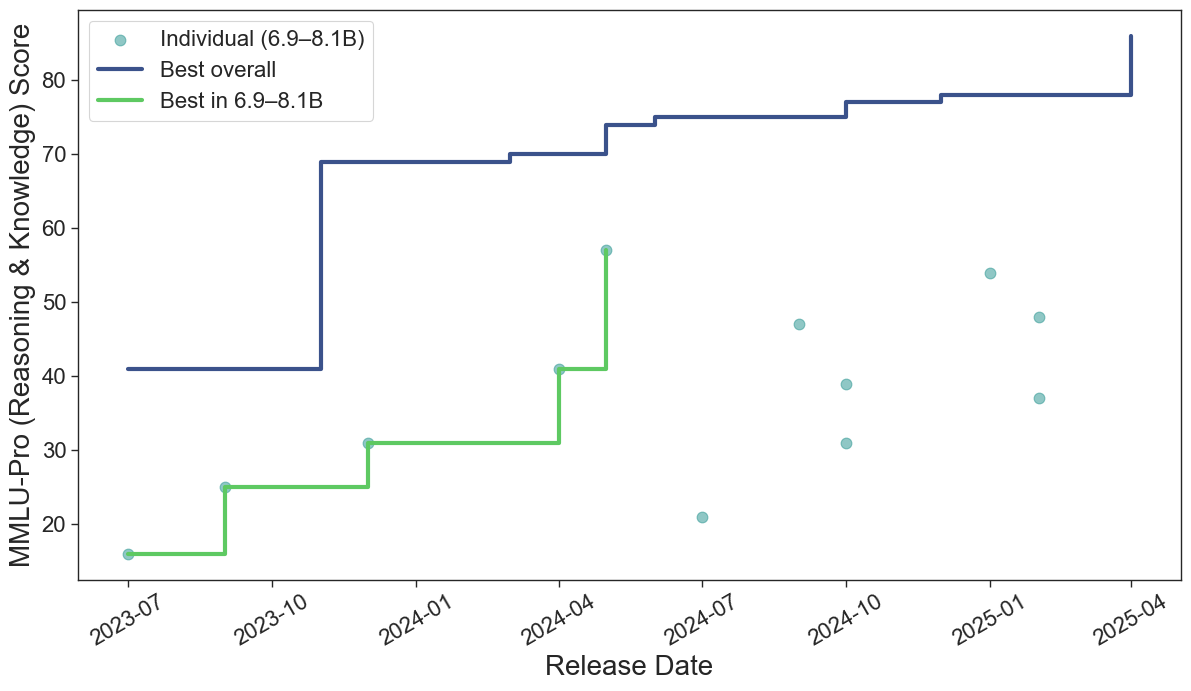

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/2800261252.py:102: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  plt.tight_layout()
/Users/hansgundlach/Documents/AllOtherResearch/NeelMaterial/othello/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8208 (\N{HYPHEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


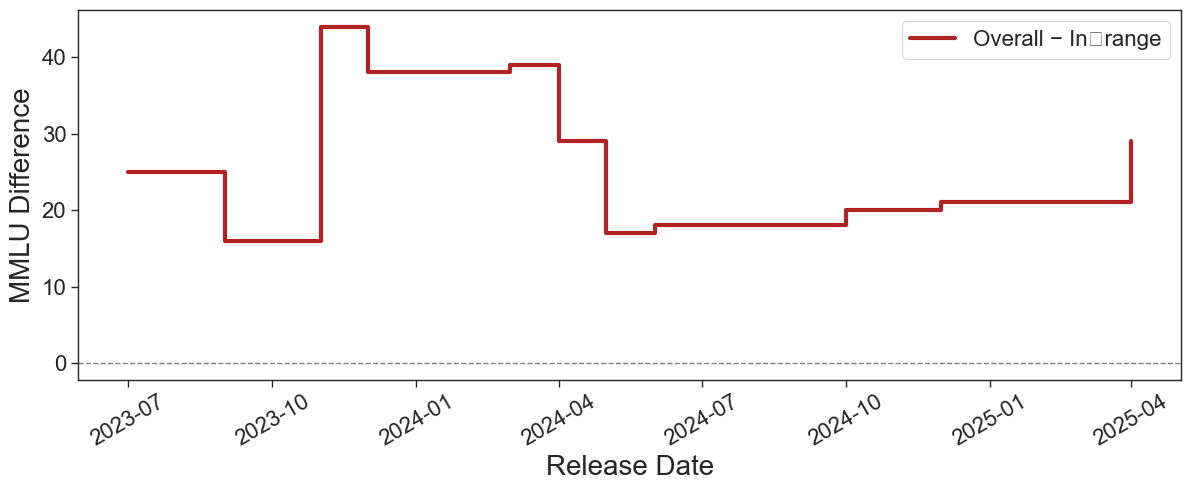

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Styling ────────────────────────────────────────────────────────────────────
sns.set_style("ticks")
sns.set_context("paper")
default_fontsize = 20
colors = sns.color_palette("viridis", n_colors=3)

# ─── User Parameters ───────────────────────────────────────────────────────────
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
lower_param = 6.9   # billions
upper_param = 8.1  # billions

# ─── Load & Clean ───────────────────────────────────────────────────────────────
df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date']    = pd.to_datetime(df['Release Date'])
df['Parameter Count'] = pd.to_numeric(df['Parameter Count'], errors='coerce')
df = df[df[benchmark_feature].notna()]

# strip “%” and convert
if df[benchmark_feature].dtype == 'object':
    df[benchmark_feature] = (
        df[benchmark_feature].str.rstrip('%').astype(float)
    )
else:
    df[benchmark_feature] = df[benchmark_feature].astype(float)

df = df.sort_values('Release Date')

# ─── Build the “best so far” curves ──────────────────────────────────────────────
# 1) overall
df_all = df.copy()
df_all['Best_MMLU_So_Far'] = df_all[benchmark_feature].cummax()
best_overall = (
    df_all[['Release Date','Best_MMLU_So_Far']]
     .drop_duplicates(subset='Best_MMLU_So_Far')
     .set_index('Release Date')['Best_MMLU_So_Far']
)
# drop duplicate dates if any
best_overall = best_overall[~best_overall.index.duplicated(keep='first')]

# 2) in‐range
in_range = df[
    (df['Parameter Count'] >= lower_param) &
    (df['Parameter Count'] <= upper_param)
].sort_values('Release Date')
in_range['Best_MMLU_In_Range'] = in_range[benchmark_feature].cummax()
best_in_range = (
    in_range[['Release Date','Best_MMLU_In_Range']]
     .drop_duplicates(subset='Best_MMLU_In_Range')
     .set_index('Release Date')['Best_MMLU_In_Range']
)
best_in_range = best_in_range[~best_in_range.index.duplicated(keep='first')]

# ─── Plot raw & step‐curves ─────────────────────────────────────────────────────
plt.figure(figsize=(12,7))
plt.scatter(in_range['Release Date'], in_range[benchmark_feature],
            alpha=0.5, s=60, color=colors[1],
            label=f'Individual ({lower_param}–{upper_param}B)')
plt.step(best_overall.index, best_overall.values, where='post',
         color=colors[0], linewidth=3, label='Best overall')
plt.step(best_in_range.index, best_in_range.values, where='post',
         color=colors[2], linewidth=3, label=f'Best in {lower_param}–{upper_param}B')

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# ─── Build difference curve ────────────────────────────────────────────────────
# only start once both series exist
start = max(best_overall.index.min(), best_in_range.index.min())

# union of two DatetimeIndexes, guaranteed unique & sorted
all_dates = (
    best_overall.index[best_overall.index >= start]
      .union(best_in_range.index[best_in_range.index >= start])
)

# forward‐fill each onto that shared timeline
overall_filled = best_overall.reindex(all_dates, method='ffill')
range_filled   = best_in_range.reindex(all_dates, method='ffill')
diff_curve     = overall_filled - range_filled

# ─── Plot the difference ───────────────────────────────────────────────────────
plt.figure(figsize=(12,5))
plt.step(all_dates, diff_curve.values, where='post',
         color='firebrick', linewidth=3, label='Overall − In‐range')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel('MMLU Difference', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# Joint Plot Of Both Curves

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1306773340.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


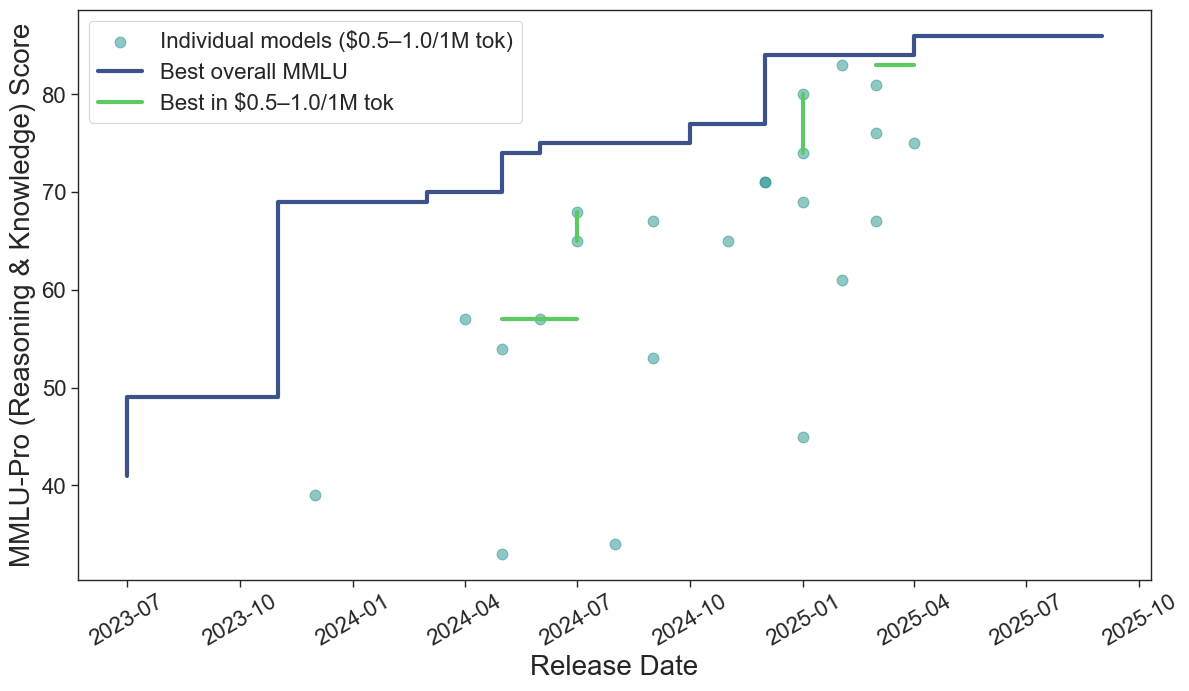

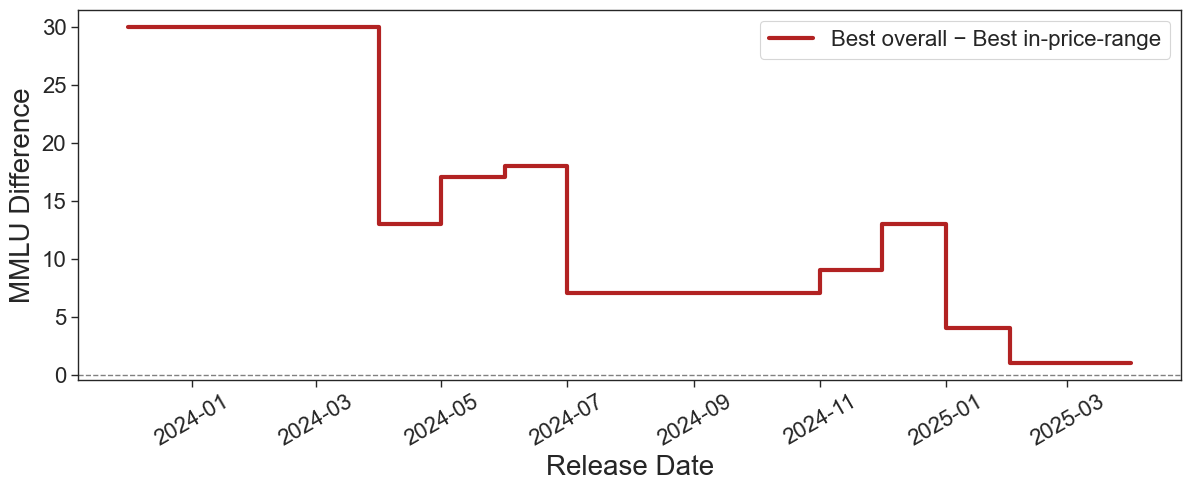

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Styling ───────────────────────────────────────────────────────────────────
sns.set_style("ticks")
sns.set_context("paper")
F = dict(fontsize=20)
colors = sns.color_palette("viridis", n_colors=3)

# ─── User parameters ───────────────────────────────────────────────────────────
# benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
benchmark_feature = 'MMLU-Pro (Reasoning & Knowledge)'
lower_price = 0.5   # USD per 1M tokens
upper_price = 1.0   # USD per 1M tokens
price_col = 'Output Price\nUSD/1M Tokens'

# ─── Load & clean ───────────────────────────────────────────────────────────────
df = pd.read_csv('Datasets/art_analysis_scrape.csv')
df['Release Date'] = pd.to_datetime(df['Release Date'])

# strip “$” and commas from the price column, convert to float
df[price_col] = (
    df[price_col].astype(str)
                .str.replace(r'[\$,]', '', regex=True)
                .astype(float)
)

# drop anything missing MMLU or Release Date
df = df[df[benchmark_feature].notna()]

# strip a trailing “%” if present, convert to float
if df[benchmark_feature].dtype == object:
    df[benchmark_feature] = (
        df[benchmark_feature].str.rstrip('%').astype(float)
    )
else:
    df[benchmark_feature] = df[benchmark_feature].astype(float)

# sort in time
df = df.sort_values('Release Date').reset_index(drop=True)

# ─── Compute both cummax series on the same timeline ────────────────────────────
# overall best
df['Best_overall'] = df[benchmark_feature].cummax()

# mark only the price‐in‐range values, NaN elsewhere
mask = df[price_col].between(lower_price, upper_price)
df['MMLU_in_price'] = df[benchmark_feature].where(mask, np.nan)

# best so far within the price range
df['Best_in_price'] = df['MMLU_in_price'].cummax()

# ─── First figure: scatter + two step‐curves ────────────────────────────────────
plt.figure(figsize=(12,7))
# scatter only the raw 0.5–1 $/1M-tok models
plt.scatter(
    df.loc[mask, 'Release Date'],
    df.loc[mask, benchmark_feature],
    alpha=0.5, s=60, color=colors[1],
    label=f'Individual models (${lower_price}–{upper_price}/1M tok)'
)

# use the full df index for both step curves
plt.step(
    df['Release Date'],
    df['Best_overall'],
    where='post', color=colors[0], linewidth=3,
    label='Best overall MMLU'
)

plt.step(
    df['Release Date'],
    df['Best_in_price'],
    where='post', color=colors[2], linewidth=3,
    label=f'Best in ${lower_price}–{upper_price}/1M tok'
)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel(f'{benchmark_feature} Score', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

# ─── Second figure: difference curve ────────────────────────────────────────────
# drop rows before the first in‐range model (where Best_in_price is still NaN)
df_diff = df.dropna(subset=['Best_in_price']).copy()
df_diff['Difference'] = df_diff['Best_overall'] - df_diff['Best_in_price']

plt.figure(figsize=(12,5))
plt.step(df_diff['Release Date'], df_diff['Difference'], where='post',
         color='firebrick', linewidth=3,
         label='Best overall − Best in-price-range')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', **F)
plt.ylabel('MMLU Difference', **F)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.tight_layout()
plt.show()

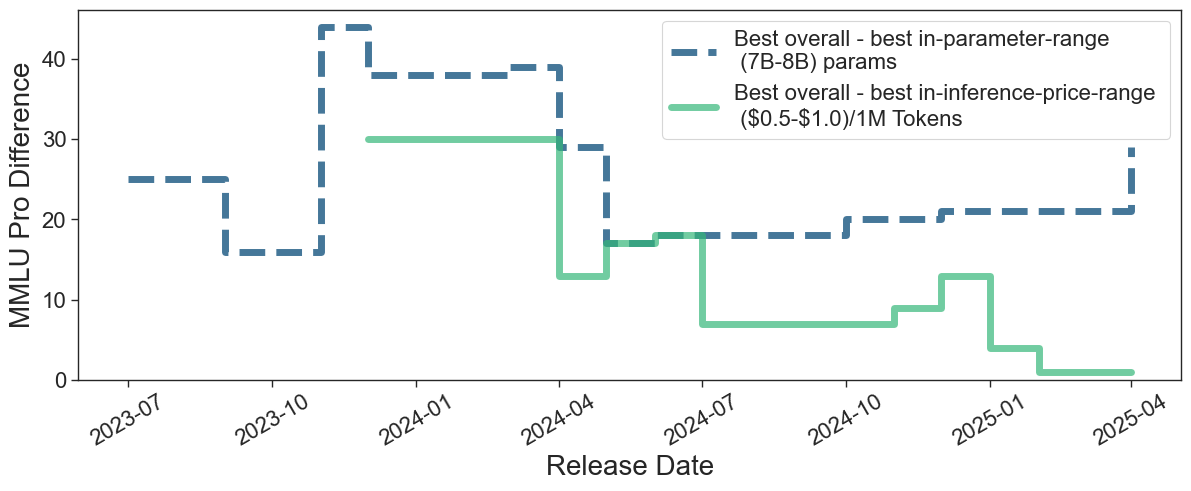

In [24]:
plt.figure(figsize=(12,5))

sns.set_style("ticks")
sns.set_context("paper")
F = dict(fontsize=20)
colors = sns.color_palette("viridis", n_colors=2)


plt.step(all_dates, diff_curve.values, where='post', linewidth=5, alpha= 0.9, label='Best overall - best in-parameter-range \n (7B-8B) params', color=colors[0], linestyle="--")
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', fontsize=default_fontsize)
plt.ylabel('MMLU Difference', fontsize=default_fontsize)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)


#infernce differnet
plt.step(df_diff['Release Date'], df_diff['Difference'], where='post', linewidth=5, alpha=0.7,
         label='Best overall - best in-inference-price-range \n (\$0.5-\$1.0)/1M Tokens', color=colors[1])
# plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Release Date', **F)
plt.ylabel('MMLU Pro Difference', **F)
plt.xticks(rotation=30, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(prop={'size':16})
plt.ylim(0)
plt.tight_layout()
plt.savefig("Figures/joint_diff_graph.png")

plt.show()

# Chatbot Arena Analysis

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_19808/1731122314.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


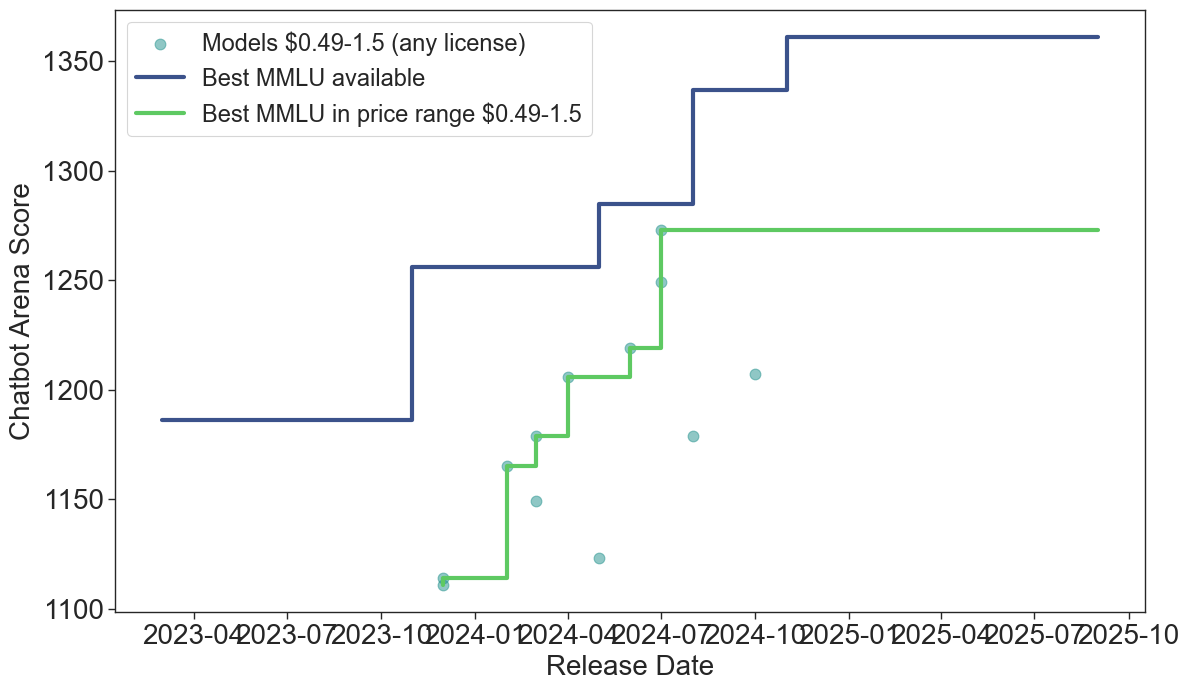

In [18]:
compare_mmlu_to_best_over_time_any_license(0.49, 1.5, benchmark_feature="Chatbot Arena")

compare_mmlu_to_best_over_time_by_param_count(6.9, 8.1, benchmark_feature="Chatbot Arena")